# 0. Loading all Data

In [2]:
%reload_ext autoreload
%autoreload 2
from B_model import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tensorflow import keras

all_metrics_df,testParamDf = data_generation()

Init Plugin
Init Graph Optimizer
Init Kernel
Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

In [45]:
result_all = pd.read_csv('result.csv')
result_all = result_all.loc[result_all['error'] != 0]
result_all_selected = result_all.loc[result_all['error'] < 1000]
result_all.shape,result_all_selected.shape

((4320, 8), (3138, 8))

In [46]:
result_all_selected

,Unnamed: 0,argu,loss_fun,class_weight,nl,opt,epochs,error
0,0,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,100.0,591.884646
1,1,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,200.0,566.150001
2,2,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,300.0,496.044002
3,3,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,100.0,410.303547
4,4,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,200.0,336.877759
...,...,...,...,...,...,...,...,...
4315,4315,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,200.0,189.592158
4316,4316,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,300.0,238.871153
4317,4317,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,100.0,444.198762
4318,4318,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,200.0,395.259875


# Plotting

In [47]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#group by argu + opt and show the mean or median or the error
def plot_tune_result(arg1,arg2,error):
    output = result_all_selected.groupby([arg1,arg2])['error'].aggregate([np.mean,np.median]).reset_index()

    ax = sns.lineplot(x = arg1, y = error, 
                data = output, 
                hue= arg2,)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set(xlabel='{}'.format(arg1), ylabel='Mean Absolute Error by Curve')
    plt.show()

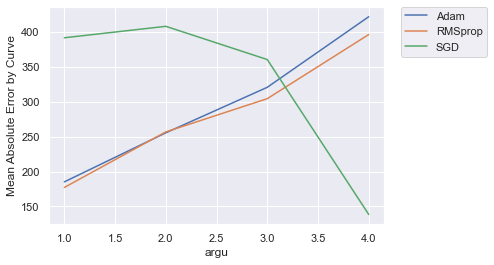

In [48]:
plot_tune_result('argu','opt','median')

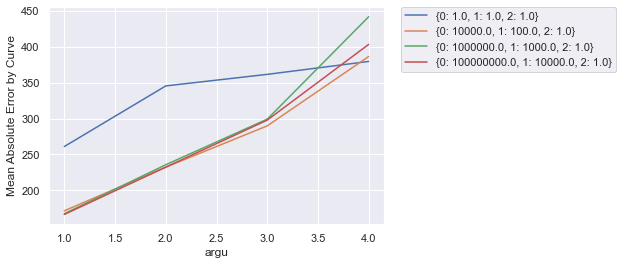

In [49]:
plot_tune_result('argu','class_weight','median')

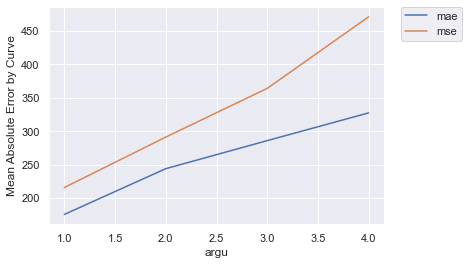

In [50]:
plot_tune_result('argu','loss_fun','median')

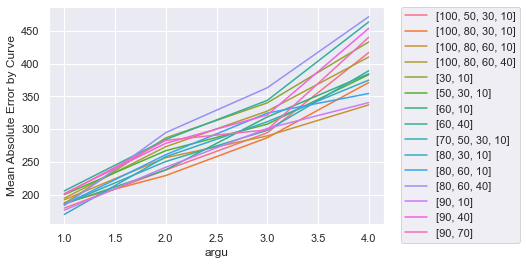

In [51]:
plot_tune_result('argu','nl','median')

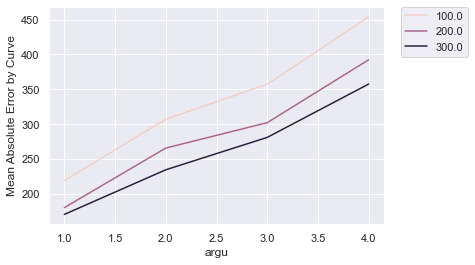

In [52]:
plot_tune_result('argu','epochs','median')

In [53]:
def plot_tune_result_3(arg1,arg2,arg3):
    output = result_all_selected.groupby([arg1,arg2,arg3])['error'].aggregate([np.mean,np.median]).reset_index()
    
    #palette = sns.color_palette("rocket_r",n_color = )
    # Plot the lines on two facets
    ax = sns.relplot(
            data=output,
            x= arg1, y= 'mean',
            hue= arg2, col= arg3,
            kind="line",
            height=10, aspect=.75, facet_kws=dict(sharex=False),
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set(xlabel='{}'.format(arg1), ylabel='Mean Absolute Error by Curve')
    plt.show()

No handles with labels found to put in legend.


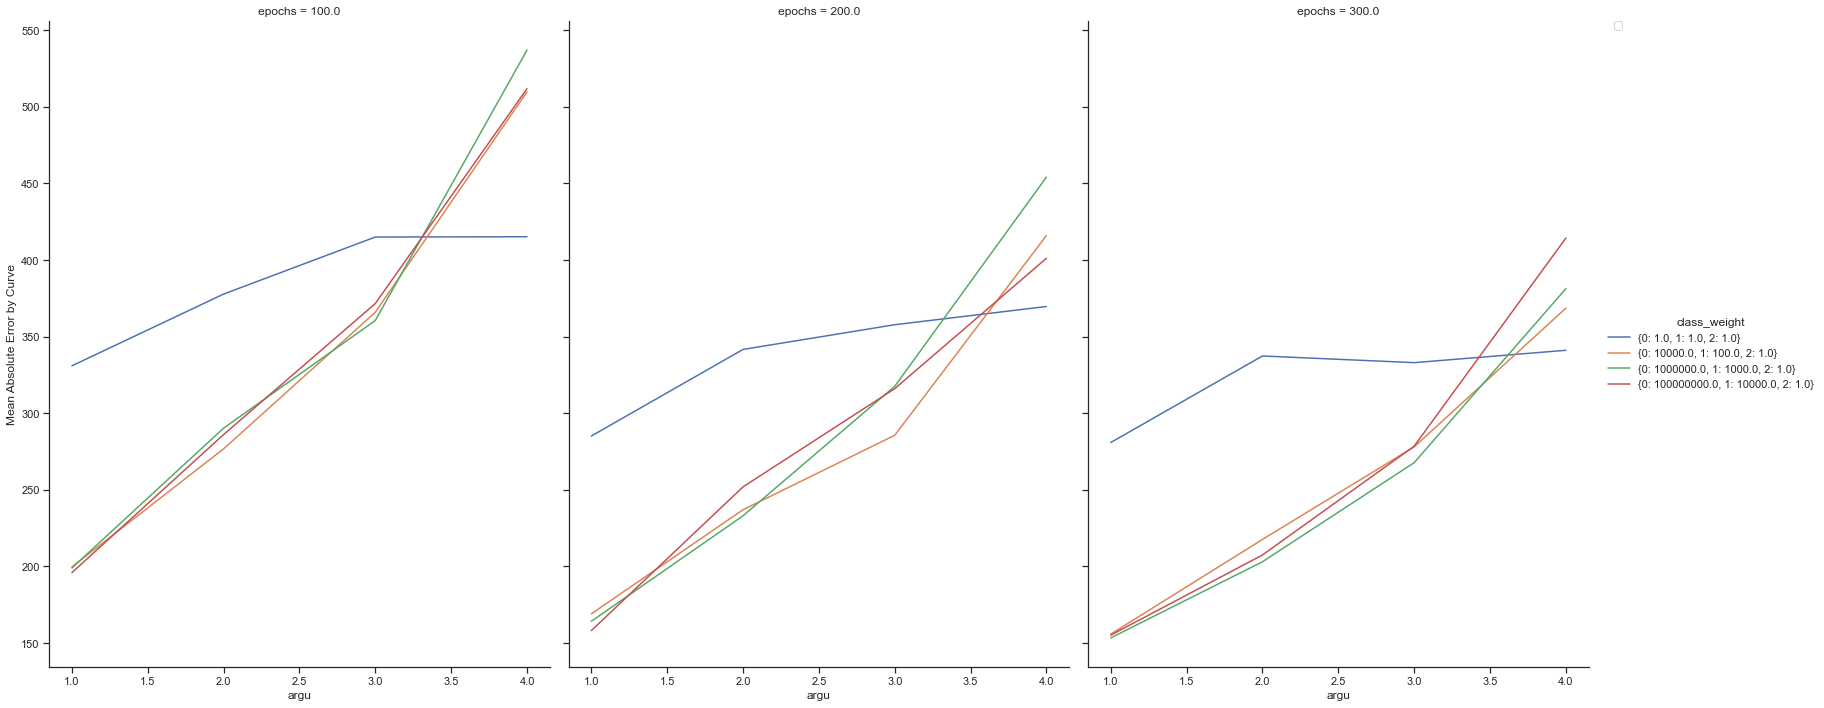

In [61]:
plot_tune_result_3('argu','class_weight','epochs')

No handles with labels found to put in legend.


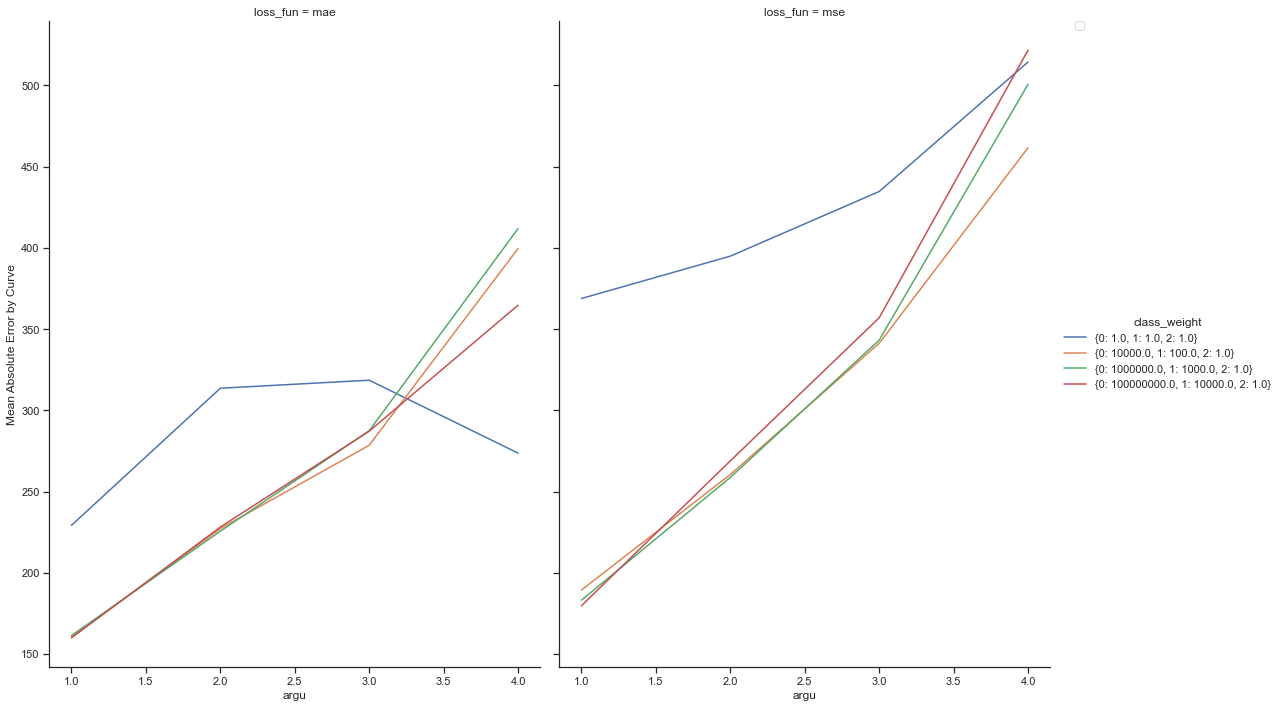

In [62]:
plot_tune_result_3('argu','class_weight','loss_fun')

In [351]:
top_30 = result_all.sorta_values(by = ['error'])[0:30].index

In [352]:
top_30

Int64Index([3881, 3780, 3872, 3834, 3789, 3843, 3827, 3863, 3835, 3809, 3825,
            4100, 3845, 3562, 1022, 2048, 3791, 3871,  715,  724,  287,  167,
             430,  984,  779,  859, 3907, 3880,  770, 3861],
           dtype='int64')

# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

# 1. Data Preparation

In [353]:
# 2nd Order Raw only!
test_coef = ["0","2","3","4","exponential"]
func_coef = ["raw","second","third","forth","exponential"]
for i in range(0,1):
    globals()[f'X{test_coef[i]}'],globals()[f'y{test_coef[i]}'],globals()[f'Y{test_coef[i]}'],globals()[f'X_Y_merged{test_coef[i]}'] = \
        eval(func_coef[i]+"_order_poly_fitting(all_metrics_df,testParamDf)")

## 1.1 Choose a Data Version

In [354]:
version = '0' #raw ones
X,y,Y,X_Y_merged = eval('X'+version),eval('y'+version),eval('Y'+version),eval('X_Y_merged'+version)
objective = eval('objective_'+version)

## 1.2 Models Construction

In [355]:
model_raw = battery_model(0,X,y,Y,X_Y_merged,objective)

## 1.3 Data Argumentation

### (Reset)

# 2. Training

In [356]:
pd.options.mode.chained_assignment = None  # default='warn'

```python
index = 0  
for i0 in argu_all:
    model_raw_copy1 = copy.deepcopy(model_raw)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    for i1 in loss_fun_all:
        for i2 in class_weight_all:
            for i3 in nl_all:
                for i4 in opt_all:
                    for i5 in epochs_all:
                        model_raw_copy = copy.deepcopy(model_raw_copy2)
                        result['argu'][index] = i0
                        result['loss_fun'][index] = i1
                        result['class_weight'][index] = "{}".format(i2)
                        result['nl'][index] = "{}".format(i3)
                        result['opt'][index] = i4
                        result['epochs'][index] = i5
                        result['error'][index] = model_raw_copy.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0)
                        index+=1
                        print (i0,i1,i2,i3,i4,i5)
```


# Result

In [337]:
#argu	loss_fun	class_weight	nl	opt	epochs	
i = 3881
i0 = int(result_all['argu'][i])
i1 = result_all['loss_fun'][i]
i2 =eval(result_all['class_weight'][i])

i3 = eval(result_all['nl'][i])

i4 = result_all['opt'][i]
i5 = int(result_all['epochs'][i])

In [414]:
model_raw_copy = copy.deepcopy(model_raw)

In [157]:
records = []
for i in top_30:
    i0 = int(result_all['argu'][i])
    i1 = result_all['loss_fun'][i]
    i2 =eval(result_all['class_weight'][i])
    i3 = eval(result_all['nl'][i])
    i4 = result_all['opt'][i]
    i5 = int(result_all['epochs'][i])
    
    model_raw_copy1 = copy.deepcopy(model_raw_copy)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    records.append(model_raw_copy2.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0))


2021-11-24 03:31:39.019986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:39.156386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:53.849125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:53.976765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:54.091651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:58.640705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:58.767314: I tensorflow/core/grappler/optimizers/cust

In [415]:
records_array = np.array(records)
select = top_30[np.argsort(records_array) == 10][0]
display(result_all.loc[2048])
#859 - Good
#770 not bad
#3825 overfitting / underfitting???
# 3881 -> WHen input dimension high (4) -> Hard to differeate those value -> tend to predict the same
# reject 4 dimension argument 


Unnamed: 0                                      2048
argu                                             2.0
loss_fun                                         mae
class_weight    {0: 100000000.0, 1: 10000.0, 2: 1.0}
nl                                  [70, 50, 30, 10]
opt                                             Adam
epochs                                         300.0
error                                      70.526142
Name: 2048, dtype: object

2021-11-24 11:18:05.218091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:18:05.447863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:18:25.142240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


216.33146565659862

In [419]:

i0 = 3
i1 = 'mae'
i2 = {0: 10000000.0, 1: 1000.0, 2: 1.0}
i3 = [100,70,50,20]
i4 = 'adam'
i5 = 200
model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(i0)
model_raw_copy2 = copy.deepcopy(model_raw_copy1)
model_raw_copy2.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0)

2021-11-24 11:19:42.604969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:19:42.743418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:19:59.486360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


182.9357358916199

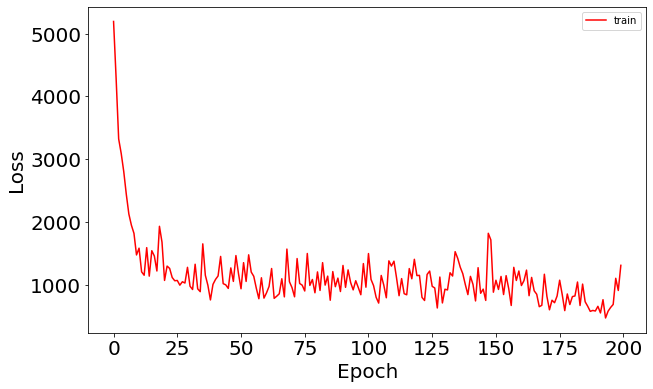

In [420]:
model_raw_copy2.loss_function_plot()

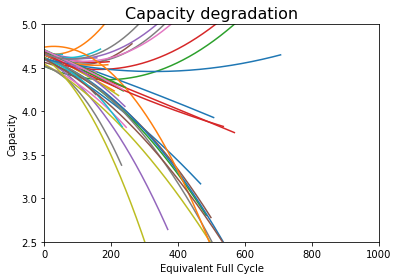

In [421]:
model_raw_copy2.plot_curve("test",all_metrics_df,1000,2.5)

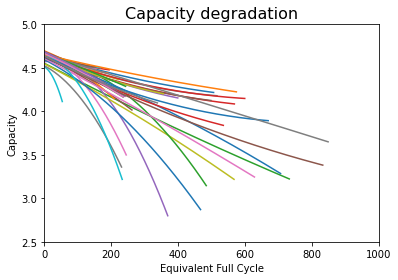

In [422]:
model_raw_copy2.plot_curve("test_true",all_metrics_df,1000,2.5)